<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

Для быстрого выполнения просмотрите [семинар](https://drive.google.com/file/d/1w_rTEWXQ_SA4YPXFjpkM0aU51bDgWLyI/view?usp=sharing).


### Models: Sentence Sentiment Classification
Our goal is to create a model that takes a sentence (just like the ones in our dataset) and produces either 1 (indicating the sentence carries a positive sentiment) or a 0 (indicating the sentence carries a negative sentiment). We can think of it as looking like this:

<img src="https://jalammar.github.io/images/distilBERT/sentiment-classifier-1.png" />

Under the hood, the model is actually made up of two model.

* DistilBERT processes the sentence and passes along some information it extracted from it on to the next model. DistilBERT is a smaller version of BERT developed and open sourced by the team at HuggingFace. It’s a lighter and faster version of BERT that roughly matches its performance.
* The next model, a basic Logistic Regression model from scikit learn will take in the result of DistilBERT’s processing, and classify the sentence as either positive or negative (1 or 0, respectively).

The data we pass between the two models is a vector of size 768. We can think of this of vector as an embedding for the sentence that we can use for classification.


<img src="https://jalammar.github.io/images/distilBERT/distilbert-bert-sentiment-classifier.png" />

## Dataset
The dataset we will use in this example is [SST2](https://nlp.stanford.edu/sentiment/index.html), which contains sentences from movie reviews, each labeled as either positive (has the value 1) or negative (has the value 0):


<table class="features-table">
  <tr>
    <th class="mdc-text-light-green-600">
    sentence
    </th>
    <th class="mdc-text-purple-600">
    label
    </th>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      apparently reassembled from the cutting room floor of any given daytime soap
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      they presume their audience won't sit still for a sociology lesson
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      this is a visually stunning rumination on love , memory , history and the war between art and commerce
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      jonathan parker 's bartleby should have been the be all end all of the modern office anomie films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
</table>

## Installing the transformers library
Let's start by installing the huggingface transformers library so we can load our deep learning NLP model.

[Transformers library doc](https://huggingface.co/transformers/)

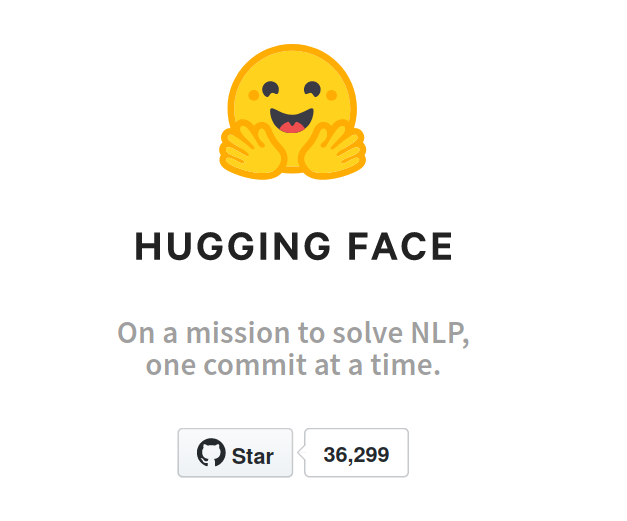

Student: Oleg Navolotsky / Олег Наволоцкий  
Stepik: https://stepik.org/users/2403189  
Telegram: [@oleg_navolotsky](https://t.me/oleg_navolotsky)  

**Note**: reproducibility depends on [different things](https://pytorch.org/docs/stable/notes/randomness.html):
>Completely reproducible results are not guaranteed across PyTorch releases, individual commits, or different platforms. Furthermore, results may not be reproducible between CPU and GPU executions, even when using identical seeds.

In [1]:
COLAB = None
DONT_USE_GPU = None

if COLAB is None:
    try:
        import google.colab
    except ModuleNotFoundError:
        COLAB = False
    else:
        COLAB = True

if DONT_USE_GPU is None:
    DONT_USE_GPU = not COLAB

COLAB, DONT_USE_GPU

(True, False)

In [2]:
if COLAB:
    !pip install -q transformers

In [3]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir("/content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+")
    print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+


In [4]:
import os

if COLAB:
    CACHE_BASE_DIR = os.path.join(os.getcwd(), ".cache")
else:
    CACHE_BASE_DIR = r"C:\.data_science_cache"

CACHE_BASE_DIR

'/content/drive/MyDrive/MIPT_DLS_II/14.1 Домашнее задание. Transformers+/.cache'

In [5]:
import warnings

warnings.filterwarnings("ignore", module="ipykernel", category=DeprecationWarning)

In [6]:
import os
import random

import numpy as np
import torch


SEED = 2


def enable_reproducibility(
        seed=SEED, raise_if_no_deterministic=True,
        cudnn_deterministic=True, disable_cudnn_benchmarking=True):
    # https://pytorch.org/docs/stable/notes/randomness.html#avoiding-nondeterministic-algorithms
    torch.use_deterministic_algorithms(raise_if_no_deterministic)

    # https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"
    
    torch.backends.cudnn.benchmark = not disable_cudnn_benchmarking
    torch.backends.cudnn.deterministic = cudnn_deterministic

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [7]:
enable_reproducibility()

In [8]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import torch
import transformers as ppb
import warnings

### Importing the dataset

In [9]:
df = pd.read_csv(
    'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv',
    delimiter='\t',
    header=None
)
print(df.shape)
df.head()

(6920, 2)


,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


### Using BERT for text classification.

Let's now load a pre-trained BERT model. 

In [10]:
# For DistilBERT, Load pretrained model/tokenizer:

model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(
    pretrained_weights,
    cache_dir=os.path.join(CACHE_BASE_DIR, r"huggingface\pretrained_models\distilbert-base-uncased\tokenizers"))
model = model_class.from_pretrained(
    pretrained_weights,
    cache_dir=os.path.join(CACHE_BASE_DIR, r"huggingface\pretrained_models\distilbert-base-uncased\DistilBertModel"))

In [11]:
if DONT_USE_GPU:
    device = torch.device("cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
# look at the model
model = model.to(device)
model.eval()

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [13]:
from termcolor import colored

colors = ['red', 'green', 'blue', 'yellow']

def model_structure(layer, margin=0, item_color=0):
    for name, next_layer in layer.named_children():
        next = (0 if not list(next_layer.named_children()) else 1)
        print(colored(' ' * margin + name, colors[item_color]) + ':' * next)
        model_structure(next_layer, margin + len(name) + 2, (item_color + 1) % 4)

model_structure(model)

embeddings:
            word_embeddings
            position_embeddings
            LayerNorm
            dropout
transformer:
             layer:
                    0:
                       attention:
                                  dropout
                                  q_lin
                                  k_lin
                                  v_lin
                                  out_lin
                       sa_layer_norm
                       ffn:
                            dropout
                            lin1
                            lin2
                       output_layer_norm
                    1:
                       attention:
                                  dropout
                                  q_lin
                                  k_lin
                                  v_lin
                                  out_lin
                       sa_layer_norm
                       ffn:
                            dropout
                      

### Preparing the dataset

In [14]:
reviews, labels = df[0], df[1]

In [15]:
from torch.utils.data import Dataset, random_split

class ReviewsDataset(Dataset):
    def __init__(self, reviews, tokenizer, labels):
        # tokenized reviews
        self.tokenized = [tokenizer.encode(text) for text in reviews]
        self.labels = list(labels)
        
    def __getitem__(self, idx):
        return {"tokenized": self.tokenized[idx], "label": self.labels[idx]}

    def __len__(self):
        return len(self.labels)

dataset = ReviewsDataset(reviews, tokenizer, labels)

# DON'T CHANGE, PLEASE
train_size, val_size = int(.8 * len(dataset)), int(.1 * len(dataset))
torch.manual_seed(2) 
train_data, valid_data, test_data = random_split(dataset, [train_size, val_size, len(dataset) - train_size - val_size])

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 5536
Number of validation examples: 692
Number of testing examples: 692


In [16]:
from torch.utils.data import Sampler

class ReviewsSampler(Sampler):
    def __init__(self, subset, batch_size=32, drop_last=False):
        self.subset = subset
        self.batch_size = batch_size
        self.drop_last = drop_last

        self.indices = subset.indices      

        # Creating an ndarray from ragged nested sequences
        # (which is a list-or-tuple of lists-or-tuples-or ndarrays
        # with different lengths or shapes)
        # is deprecated:
        # self.tokenized = np.array(subset.dataset.tokenized)[self.indices]
        
        # tokenized for our data
        self.tokenized = [subset.dataset[idx]['tokenized'] for idx in self.indices]
        

    def __iter__(self):
        batch_idx = []
        # index in sorted data
        for index in np.argsort(list(map(len, self.tokenized))):
            batch_idx.append(index)
            if len(batch_idx) == self.batch_size:
                yield batch_idx
                batch_idx = []

        if not self.drop_last and len(batch_idx) > 0:
            yield batch_idx
    
    # original:
    # def __len__(self):
    #     return len(self.dataset)

    def __len__(self):
        if self.drop_last:
            return len(self.indices) // self.batch_size
        else:
            return (len(self.indices) + self.batch_size - 1) // self.batch_size


In [17]:
from torch.utils.data import DataLoader

def get_padded(values):
    max_len = 0
    for value in values:
        if len(value) > max_len:
            max_len = len(value)

    padded = np.array([value + [0]*(max_len-len(value)) for value in values])

    return padded

def collate_fn(batch):
    inputs = []
    labels = []
    for elem in batch:
        inputs.append(elem['tokenized'])
        labels.append(elem['label'])

    inputs = get_padded(inputs)  # padded inputs
    attention_mask = np.where(inputs != 0, 1, 0)

    return {
        "inputs": torch.tensor(inputs),
        "labels": torch.FloatTensor(labels),
        'attention_mask' : torch.tensor(attention_mask)
    }

train_loader = DataLoader(train_data, batch_sampler=ReviewsSampler(train_data), collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_sampler=ReviewsSampler(valid_data), collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_sampler=ReviewsSampler(test_data), collate_fn=collate_fn)

### Baseline

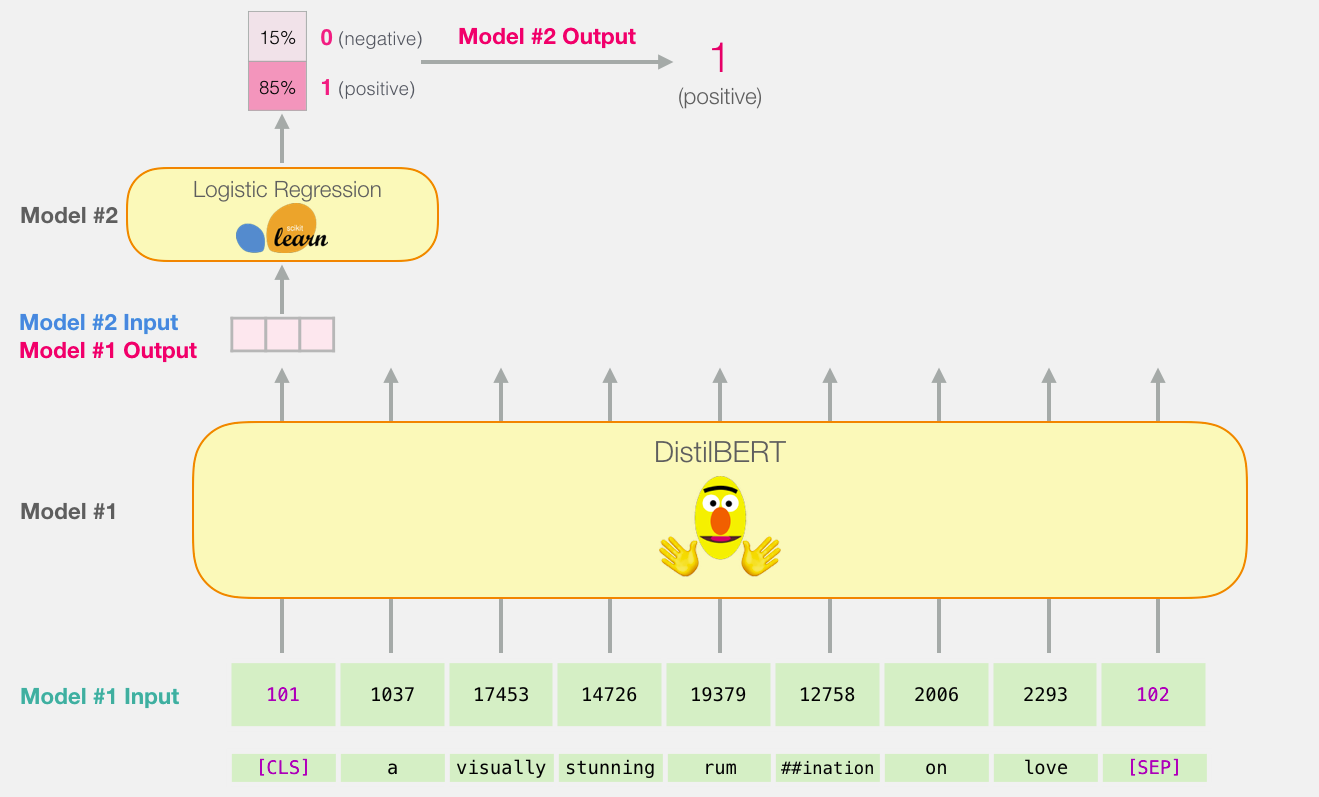

In [18]:
from tqdm.notebook import tqdm

@torch.no_grad()
def get_xy(model, loader):
    model.eval()

    features = []
    labels = []

    for batch in tqdm(loader):

        inputs = batch['inputs'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        labels.append(batch['labels'])
        
        outputs = model(inputs, attention_mask=attention_mask)
        
        features.append(outputs.last_hidden_state)

    batch_size_dim = 0
    cls_token_idx = 0
    # Must slice before cat() because batches have different sequence length:
    features = torch.cat([elem[:, cls_token_idx] for elem in features], dim=batch_size_dim)
    labels = torch.cat(labels, dim=batch_size_dim)
    
    return features.cpu().numpy(), labels.cpu().numpy()

In [19]:
train_features, train_labels = get_xy(model, train_loader)
valid_features, valid_labels = get_xy(model, valid_loader)
test_features, test_labels = get_xy(model, test_loader)

In [20]:
train_features[0].shape 

(768,)

In [21]:
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

0.819364161849711

### Fine-Tuning BERT

Define the model

In [22]:
from torch import nn

class BertClassifier(nn.Module):
    def __init__(self, pretrained_model, dropout=0.1, num_classes=1, num_layers_from_enc_to_use_in_clsf=4, cls_token_idx=0):
        super().__init__()
        self.bert = pretrained_model
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.num_layers_from_enc_to_use_in_clsf = num_layers_from_enc_to_use_in_clsf
        self.cls_token_idx = cls_token_idx
        self.linear = nn.Linear(
            pretrained_model.config.dim * num_layers_from_enc_to_use_in_clsf,
            num_classes)
    
    def forward(self, inputs, attention_mask):
        hidden_states = self.bert(
            inputs, attention_mask, output_hidden_states=True).hidden_states
        features = torch.cat(
            hidden_states[-self.num_layers_from_enc_to_use_in_clsf:], dim=-1
        )[:, self.cls_token_idx]
        proba = self.linear(self.dropout(self.relu(features)))
        return proba

In [23]:
import torch.optim as optim

# DON'T CHANGE
# ok, just have set `cache_dir`
model = model_class.from_pretrained(
    pretrained_weights,
    cache_dir=os.path.join(CACHE_BASE_DIR, r"huggingface\pretrained_models\distilbert-base-uncased\DistilBertModel"))
# model = model.to(device)  # It's not necessary because of the next line.
bert_clf = BertClassifier(model).to(device)
# you can change
optimizer = optim.Adam(bert_clf.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()  # here was nn.BCELoss()
bert_clf

BertClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_feat

In [24]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None, device='cpu'):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        inputs = batch['inputs'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        output = model(inputs, attention_mask)

        loss = criterion(output, labels.unsqueeze(-1)) 
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / (i + 1)

@torch.no_grad()
def evaluate(model, iterator, criterion, device='cpu'):
    model.eval() 
    epoch_loss = 0
    history = []
    
    for i, batch in enumerate(iterator):

        inputs = batch['inputs'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        output = model(inputs, attention_mask)
        
        loss = criterion(output, labels.unsqueeze(-1))
        
        epoch_loss += loss.item()
        
    return epoch_loss / (i + 1)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [25]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

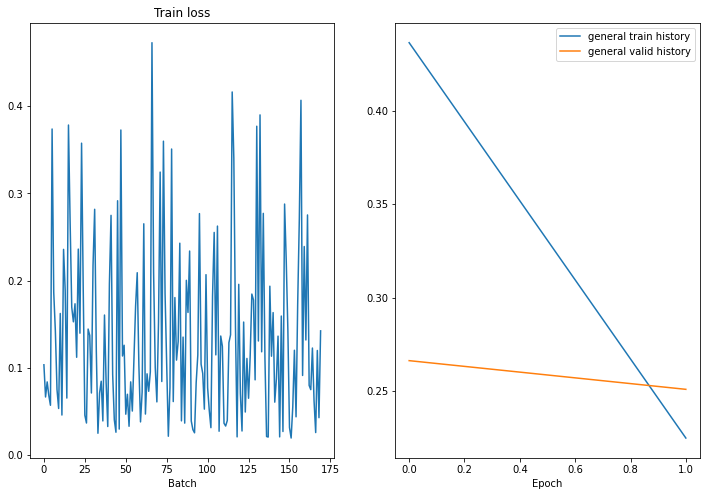

Epoch: 03 | Time: 0m 20s
	Train Loss: 0.136 | Train PPL:   1.146
	 Val. Loss: 0.275 |  Val. PPL:   1.316


In [26]:
enable_reproducibility()

train_history = []
valid_history = []

N_EPOCHS = 3
CLIP = 1

best_valid_loss = float('inf')

trained_model = bert_clf
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(trained_model, train_loader, optimizer, criterion, CLIP, train_history, valid_history, device=device)
    valid_loss = evaluate(trained_model, valid_loader, criterion, device=device)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(trained_model.state_dict(), f'{trained_model.__class__.__name__}-best-val-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [27]:
torch.save(trained_model.state_dict(), f'{trained_model.__class__.__name__}-last-model.pt')

In [28]:
best_model = BertClassifier(model).to(device)
best_model.load_state_dict(torch.load(f'{best_model.__class__.__name__}-best-val-model.pt'))
next(best_model.parameters()).device

device(type='cuda', index=0)

In [29]:
pred_labels = []
true_labels = []

tested_model = best_model
tested_model.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_loader), total=len(test_loader)):
        inputs = batch['inputs'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = tested_model(inputs, attention_mask)

        true_labels.append(labels.cpu().numpy())

        pred_labels.append((torch.sigmoid(logits) > 0.5).cpu().numpy())

In [30]:
from sklearn.metrics import accuracy_score

true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)
accuracy_score(true_labels, pred_labels)

0.8641618497109826

In [31]:
assert accuracy_score(true_labels, pred_labels) >= 0.86

### Finetuned model from **HUGGING FACE**

[BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html?highlight=bertfor#transformers.BertForSequenceClassification)

In [32]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# we have the same tokenizer
# new_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
new_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english",
    cache_dir=os.path.join(CACHE_BASE_DIR, r"huggingface\pretrained_models\distilbert-base-uncased-finetuned-sst-2-english\AutoModelForSequenceClassification")
    ).to(device)

In [33]:
pred_labels = []
true_labels = []

tested_model = new_model
tested_model.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_loader), total=len(test_loader)):
        inputs = batch['inputs'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = tested_model(inputs, attention_mask)

        true_labels.append(labels.cpu().numpy())

        pred_labels.append(outputs.logits.argmax(-1).cpu().numpy())

true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)
accuracy_score(true_labels, pred_labels)

0.9841040462427746

In [34]:
new_model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [35]:
model_structure(new_model)

distilbert:
            embeddings:
                        word_embeddings
                        position_embeddings
                        LayerNorm
                        dropout
            transformer:
                         layer:
                                0:
                                   attention:
                                              dropout
                                              q_lin
                                              k_lin
                                              v_lin
                                              out_lin
                                   sa_layer_norm
                                   ffn:
                                        dropout
                                        lin1
                                        lin2
                                   output_layer_norm
                                1:
                                   attention:
                                              dropo

## Напишите вывод о своих результатах. В выводы включите ваши гиперпараметры. 

*Качество с помощью Fine-Tuning должно достигать 0.86.*



Гиперпараметры я не менял: число эпох (3) и lr (2e-5) оставлены без изменений. В качестве классификатора использован один линейный слой, входом в который являются hidden state CLS-токена с последних четырёх слоёв, как это было предложено на лекции. Правда, там это было сделано для NER Task (хотя её, наверное, тоже можно решать как задачу бинарной классификации) и для модели __BERT Base__, в которой 12 слоёв по 12 голов с размером скрытого представления токенов, равным 768, а в модели __DistilBERT__ слоев всего 6. Возможно, различаются и структуры attention, feed forward слоёв и т.д. Тем не менее, для пробития порога 0.86 этого оказалось достаточно. 

Учится модель очень быстро, что порадовало. Если бы было больше времени, то поигравшись с архитектурой и параметрами, наверняка можно было достичь большего значения accuracy.

Модель `DistilBertForSequenceClassification` с fine-tuned весами `distilbert-base-uncased-finetuned-sst-2-english`, по моему мнению, показывает неадекватно высокие результаты. Да, в классификаторе два слоя и использовано другое значение dropout, но вряд ли это бы так сильно повлияло на performance. Да, модель дообучена конкретно для задачи бинарной классификации сантимента, причём именно на __SST2__, но [здесь](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) указано, что она достигает accuracy of 91.3 на некоем _dev set_. Скорей всего, наш тестовый датасет — подмножество данных, использованных для fine-tuning'а этой модели. Видимо, это так и есть, поскольку [репозиторий](https://github.com/clairett/pytorch-sentiment-classification/tree/master/data/SST2), откуда мы загрузили _train.tsv_, содержит ещё _dev.tsv_ и _test.tsv_, наверное, являющиеся преобразованным [оригинальным](https://nlp.stanford.edu/sentiment/index.html) датасетом. 